# Load representations, Jacobians, and distances
### Some example analysis code

In [1]:
import torch
import torchinfo
import torch.nn as nn
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import dsutils 
import metrics
import jsutils

import os
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.manifold import MDS
from sklearn.decomposition import PCA

import pickle

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [2]:
# Probe images used

fnames = os.listdir('../imagenet-sample-images/dataset/test/')
fnames.sort()

In [41]:
# Load deep representations (if needed)

with open('internal_reps_with_model_2nd_half.pkl', 'rb') as f:
    repDict = pickle.load(f)


In [5]:
# Load Jacobians r by n

J_dict_rbyn = {}

model_names = ["alexnet", "resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "inceptionv3","vgg16"]
# model_names = ["alexnet", "resnet18"]


N_models = len(model_names)
for model_name in model_names:
    with open(model_name + '_decoding_Js.pkl', 'rb') as f:
        new_J = pickle.load(f)
        J_dict_rbyn.update(new_J)
        print(model_name)

vgg19
vgg19_bn


In [3]:
# Load Jacobians m by n

import pickle

J_dict_mbyn = {}

model_names = ["alexnet", "resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "inceptionv3","vgg16"]

N_models = len(model_names)
for model_name in model_names:
    with open(model_name + '_decoding_Js_mbyn.pkl', 'rb') as f:
        new_J = pickle.load(f)
        J_dict_mbyn.update(new_J)
        print(model_name)

alexnet
resnet18
resnet34
resnet50
resnet101
resnet152
inceptionv3
vgg16


In [3]:
# Load flattened Jacobians

import pickle

J_dict = {}

# model_names = ["alexnet", "resnet18", "resnet34", "resnet50", "resnet101", "resnet152", "densenet", "mobilenetv2","vgg11", "vgg16", "vgg16_bn", "vgg19", "vgg19_bn"]
model_names = ["alexnet", "resnet18", "resnet34", "resnet50", "resnet101", "resnet152","vgg16"]

N_models = len(model_names)
for model_name in model_names:
    with open(model_name + '_decoding_Js_stacked.pkl', 'rb') as f:
        new_J = pickle.load(f)
        J_dict.update(new_J)
        print(model_name)

alexnet
resnet18
resnet34
resnet50
resnet101
resnet152
vgg16


In [73]:
# Load Bures distance matrices between r by N Jacobians

bures_dict = np.load('bures_dists_penultimate_decoding_Jrbyn.npz')

In [51]:
# Load Bures distance matrices between M by N Jacobians

bures_dict = np.load('bures_dists_penultimate_decoding_Jmbyn.npz')

In [52]:
# Load Bures distance matrix between flattened Jacobians (r*M by N)

bures_dict_flat = np.load('proc_dists_penultimate_decoding_Jstacked.npz')

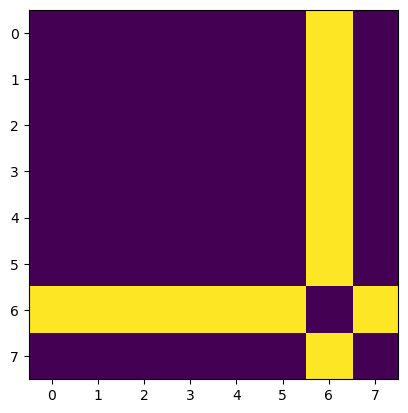

In [74]:
plt.imshow(bures_dict["bures_dists"][55])

In [75]:
# INSPECTION AND ANALYSIS

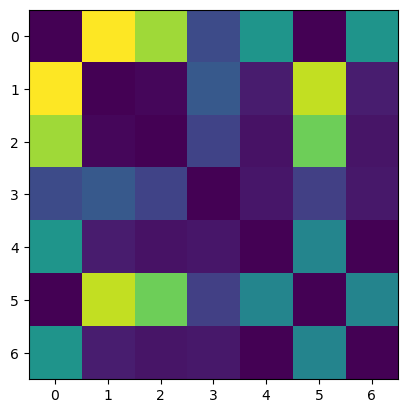

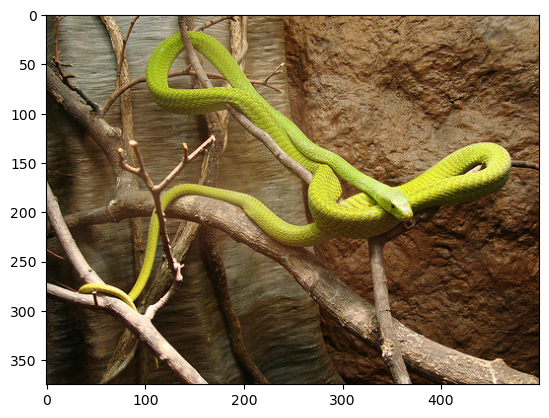

In [76]:
# Look at a distance matrix for a single image or category

index = 55
bures_dist_single = bures_dict["bures_dists"][index]
model_names = bures_dict["model_names"]

# Delete inceptionv3 because it is really far from the others
bures_dist_single = np.delete(bures_dist_single,6,axis=0)
bures_dist_single = np.delete(bures_dist_single,6,axis=1)
model_names = np.delete(model_names,6)

plt.figure()
plt.imshow(bures_dist_single)

trial_image = fnames[index]
input_image = Image.open('../imagenet-sample-images/dataset/test/'+ trial_image)

plt.figure()
plt.imshow(input_image)

In [77]:
embedding = MDS(n_components=10, metric= True, eps = 0.00001, normalized_stress='auto', dissimilarity='precomputed')
Z = embedding.fit_transform(bures_dist_single)
embedding.stress_

np.float64(5.7227460065198214e-11)

In [78]:
pca = PCA(n_components=2)
pcs1 = pca.fit_transform(Z)
np.sum(pca.explained_variance_ratio_)

np.float64(0.9825924500345656)

Text(0.5, 1.0, 'Bures distance between r by N Jacobians for image 55')

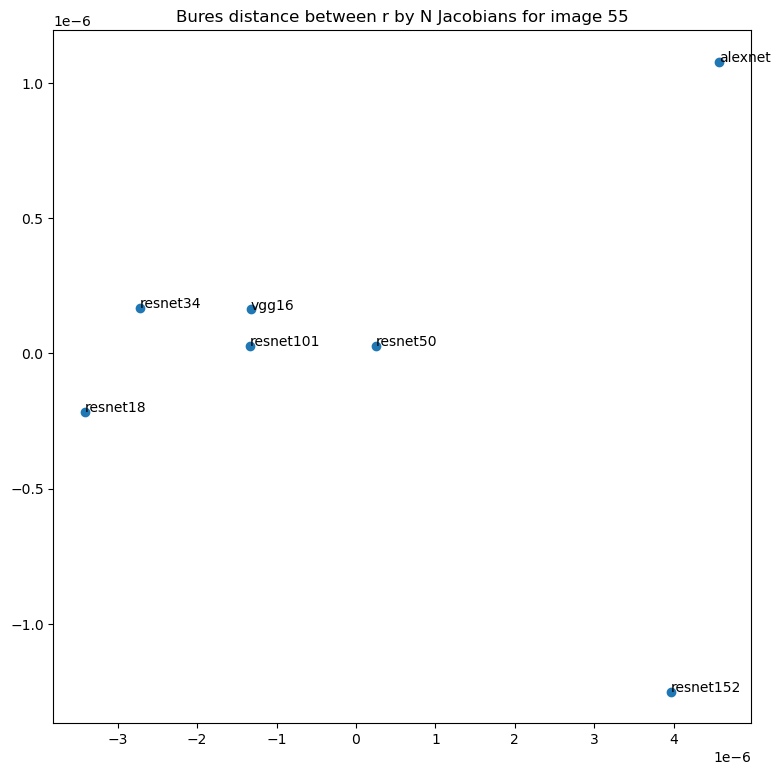

In [79]:
fig = plt.figure(figsize= (9,9))
ax = fig.add_subplot(1,1,1)

ax.scatter(pcs1[:,0], pcs1[:,1])

for i, txt in enumerate(model_names):
    ax.text(pcs1[i,0], pcs1[i,1],txt)

plt.title('Bures distance between r by N Jacobians for image ' + str(index))

In [80]:
# Average over all images

bures_dists_all_rbyn = bures_dict["bures_dists"]
model_names = bures_dict["model_names"]

bures_dists_mean = np.zeros(bures_dict["bures_dists"][0].shape)
for j in range(bures_dists_all_rbyn[0].shape[0]):
    for k in range(bures_dists_all_rbyn[0].shape[0]):
        bures_dists_mean[j,k] = np.mean([bures_dists_all_rbyn[i][j,k] for i in range(len(bures_dists_all_rbyn))])


In [59]:
# Average over all categories

# bures_dists_all_mbyn = bures_dict["bures_dists"]
# model_names = bures_dict["model_names"]

# bures_dists_mean = np.zeros(bures_dict["bures_dists"][0].shape)
# for j in range(bures_dists_all_mbyn[0].shape[0]):
#     for k in range(bures_dists_all_mbyn[0].shape[0]):
#         bures_dists_mean[j,k] = np.mean([bures_dists_all_mbyn[i][j,k] for i in range(len(bures_dists_all_mbyn))])


In [81]:
# Delete some models

bures_dists_mean = np.delete(bures_dists_mean,6,axis=0)
bures_dists_mean = np.delete(bures_dists_mean,6,axis=1)
model_names = np.delete(model_names,6)

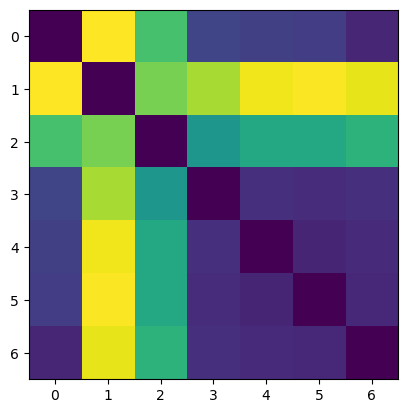

In [82]:
plt.imshow(bures_dists_mean)

In [86]:
embedding = MDS(n_components=10, metric= True, eps = 0.00001, normalized_stress='auto', dissimilarity='precomputed')
Z = embedding.fit_transform(bures_dists_mean)
embedding.stress_

np.float64(4.518136327542007e-10)

In [87]:
pca = PCA(n_components=2)
pcs1 = pca.fit_transform(Z)
np.sum(pca.explained_variance_ratio_)

np.float64(0.9620958424292404)

Text(0.5, 1.0, 'Bures distance between r by N Jacobians averaged over 1000 sample inputs')

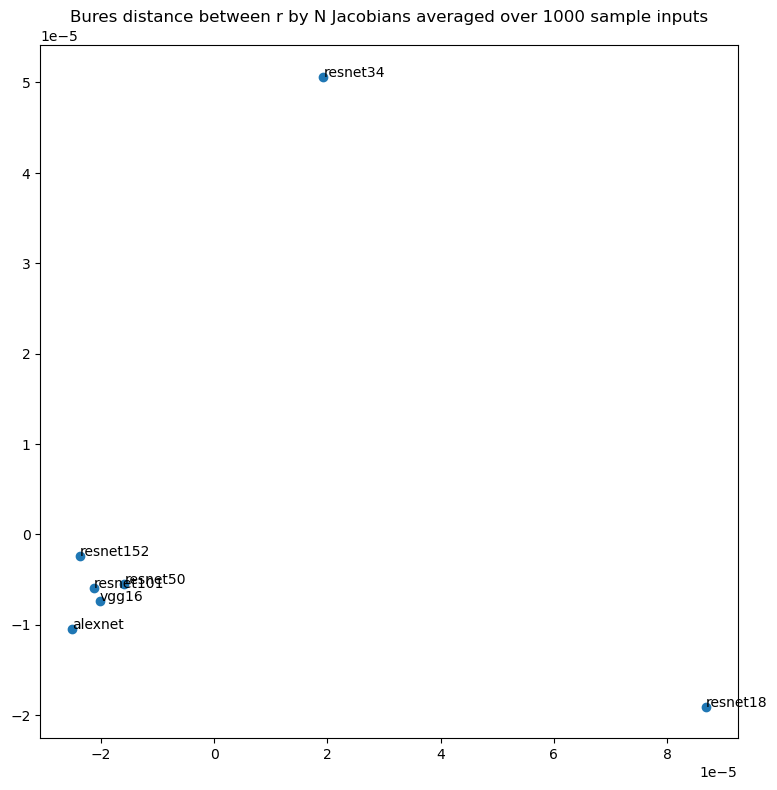

In [88]:
fig = plt.figure(figsize= (9,9))
ax = fig.add_subplot(1,1,1)

ax.scatter(pcs1[:,0], pcs1[:,1])

for i, txt in enumerate(model_names):
    ax.text(pcs1[i,0], pcs1[i,1],txt)

plt.title('Bures distance between r by N Jacobians averaged over 1000 sample inputs')

In [ ]:
# Look at flattened Jacobian Bures distances

In [67]:
# Average over all images

bures_dist_flat = bures_dict_flat["bures_dists"][0]
model_names = bures_dict_flat["model_names"]


In [68]:
# Delete some models

bures_dist_flat = np.delete(bures_dist_flat,6,axis=0)
bures_dist_flat = np.delete(bures_dist_flat,6,axis=1)
model_names = np.delete(model_names,6)

bures_dist_flat = np.delete(bures_dist_flat,6,axis=0)
bures_dist_flat = np.delete(bures_dist_flat,6,axis=1)
model_names = np.delete(model_names,6)

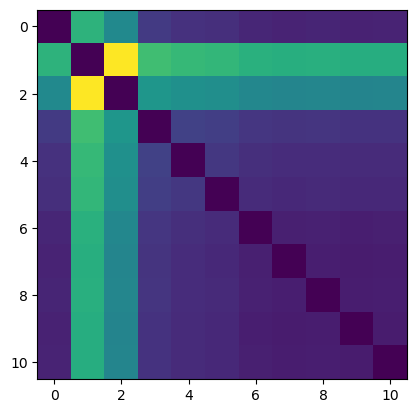

In [69]:
plt.imshow(bures_dist_flat)


In [70]:
embedding = MDS(n_components=10, metric= True, eps = 0.00001, normalized_stress='auto', dissimilarity='precomputed')
Z = embedding.fit_transform(bures_dist_flat)
embedding.stress_

np.float64(9.274096079521003e-05)

In [71]:
pca = PCA(n_components=2)
pcs1 = pca.fit_transform(Z)
np.sum(pca.explained_variance_ratio_)

np.float64(0.9212385567518047)

Text(0.5, 1.0, 'Bures distance between M*r by N Jacobians')

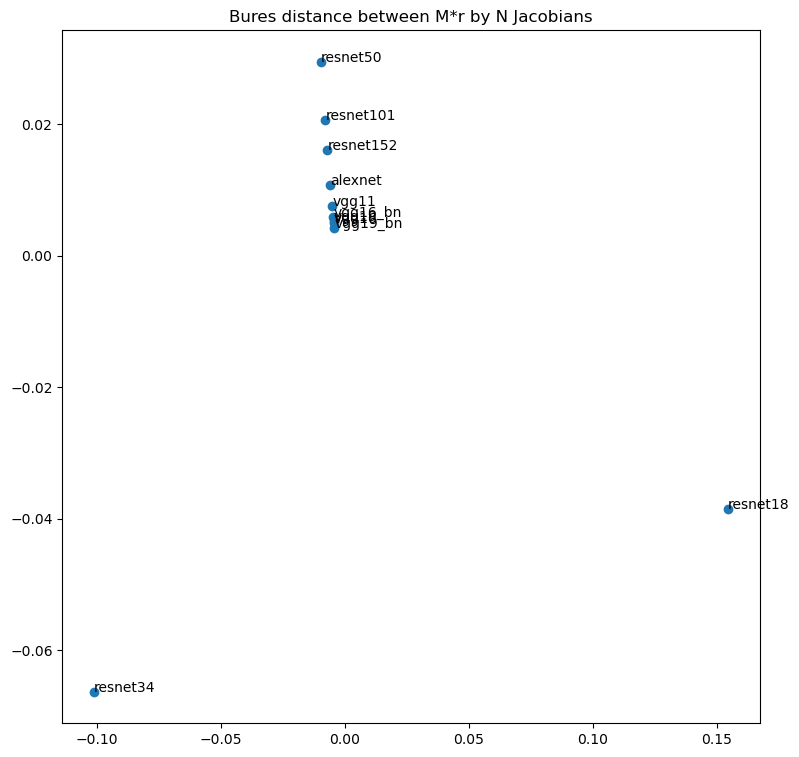

In [72]:
fig = plt.figure(figsize= (9,9))
ax = fig.add_subplot(1,1,1)

ax.scatter(pcs1[:,0], pcs1[:,1])

for i, txt in enumerate(model_names):
    ax.text(pcs1[i,0], pcs1[i,1],txt)

plt.title('Bures distance between M*r by N Jacobians')